In [11]:
#Importing needed modules .
import os
from shutil import copyfile , rmtree
import random as rn

In [14]:
#Creating basic paths .
def Make_basic_paths(path)-> tuple :
    '''function docstring'''
    if 'ready_to_gen' in os.listdir(path) :
        rmtree(f'{path}\\ready_to_gen')
    os.mkdir(f'{path}\\ready_to_gen')
    os.mkdir(f'{path}\\ready_to_gen\\train')
    os.mkdir(f'{path}\\ready_to_gen\\valid')
    return (f'{path}\\ready_to_gen\\train',f'{path}\\ready_to_gen\\valid')

In [15]:
path = 'D:\\datasets\\Large_scale_fishes'
Make_basic_paths(path)

('D:\\datasets\\Large_scale_fishes\\ready_to_gen\\train',
 'D:\\datasets\\Large_scale_fishes\\ready_to_gen\\valid')

In [16]:
fishes_dir = 'D:\\datasets\\Large_scale_fishes\\Fish_Dataset\\Fish_Dataset'
os.listdir(fishes_dir)

['Black Sea Sprat',
 'Gilt-Head Bream',
 'Hourse Mackerel',
 'license.txt',
 'README.txt',
 'Red Mullet',
 'Red Sea Bream',
 'Sea Bass',
 'Segmentation_example_script.m',
 'Shrimp',
 'Striped Red Mullet',
 'Trout']

In [17]:
#Splitting data to train and valid .
def Split_data(Dir,train_size)->None :
    '''function docstring'''
    for folder in os.listdir(Dir) :
        if '.txt' in folder or 'Segmentation' in folder :
            continue
        os.mkdir(f'D:\\datasets\\Large_scale_fishes\\ready_to_gen\\train\\{folder}')
        os.mkdir(f'D:\\datasets\\Large_scale_fishes\\ready_to_gen\\valid\\{folder}')
        idx = (train_size*len(os.listdir(f'{Dir}\\{folder}\\{folder}')))//100
        selected_pics = rn.sample(os.listdir(f'{Dir}\\{folder}\\{folder}'),idx)
        for pic in os.listdir(f'{Dir}\\{folder}\\{folder}') :
            if pic in selected_pics :
                copyfile(f'{Dir}\\{folder}\\{folder}\\{pic}',f'D:\\datasets\\Large_scale_fishes\\ready_to_gen\\train\\{folder}\\{pic}')
            else :
                copyfile(f'{Dir}\\{folder}\\{folder}\\{pic}',f'D:\\datasets\\Large_scale_fishes\\ready_to_gen\\valid\\{folder}\\{pic}')

In [18]:
try :
    size = int(input('Enter training size :'))
    Split_data(fishes_dir,size)
    print('All done')
except :
    print('something wrong whith function')

Enter training size :90
All done


In [19]:
#Creating instances of image generators . 
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_gen = ImageDataGenerator(rescale=1/255,rotation_range=40,width_shift_range=0.2,height_shift_range=0.2,shear_range=0.2,horizontal_flip=True,zoom_range=0.2)
valid_gen = ImageDataGenerator(rescale=1/255)

In [38]:
#Generating data .
train_path = 'D:\\datasets\\Large_scale_fishes\\ready_to_gen\\train'
valid_path = 'D:\\datasets\\Large_scale_fishes\\ready_to_gen\\valid'
ready_train = train_gen.flow_from_directory(train_path,target_size=(150,150),batch_size=162)
ready_valid = valid_gen.flow_from_directory(valid_path,target_size=(150,150),batch_size=18)

Found 8100 images belonging to 9 classes.
Found 900 images belonging to 9 classes.


In [41]:
#Creating model using Inception pre trained model . 
from tensorflow.keras import layers ,Model
from tensorflow.keras.applications import InceptionV3
def Create_model()->None :
    '''function docstring'''
    pre_trained_model = InceptionV3(include_top=False,input_shape=(150,150,3))
    for layer in pre_trained_model.layers :
        layer.trainable = False 
    last_layer = pre_trained_model.get_layer('mixed7')
    last_out = last_layer.output
    x = layers.Flatten()(last_out)
    x = layers.Dense(256,activation='relu')(x)
    x = layers.Dense(9,activation='softmax')(x)
    model = Model(pre_trained_model.input,x)
    model.compile(optimizer='rmsprop',loss='categorical_crossentropy',metrics=['accuracy'])
    return model

In [42]:
#Training data .
history = Create_model().fit(ready_train,epochs=15,validation_data=ready_valid)

Epoch 1/15
50/50 [==============================] - 232s 5s/step - loss: 3.0757 - accuracy: 0.5688 - val_loss: 2.2880 - val_accuracy: 0.4311
Epoch 2/15
50/50 [==============================] - 232s 5s/step - loss: 0.5434 - accuracy: 0.8268 - val_loss: 0.2268 - val_accuracy: 0.9189
Epoch 3/15
50/50 [==============================] - 230s 5s/step - loss: 0.3498 - accuracy: 0.8881 - val_loss: 0.5925 - val_accuracy: 0.8233
Epoch 4/15
50/50 [==============================] - 229s 5s/step - loss: 0.2225 - accuracy: 0.9220 - val_loss: 0.0608 - val_accuracy: 0.9811
Epoch 5/15
50/50 [==============================] - 215s 4s/step - loss: 0.1708 - accuracy: 0.9442 - val_loss: 0.0586 - val_accuracy: 0.9811
Epoch 6/15
50/50 [==============================] - 223s 4s/step - loss: 0.1354 - accuracy: 0.9546 - val_loss: 0.1920 - val_accuracy: 0.9311
Epoch 7/15
50/50 [==============================] - 229s 5s/step - loss: 0.1199 - accuracy: 0.9601 - val_loss: 0.1839 - val_accuracy: 0.9456
Epoch 8/15
50

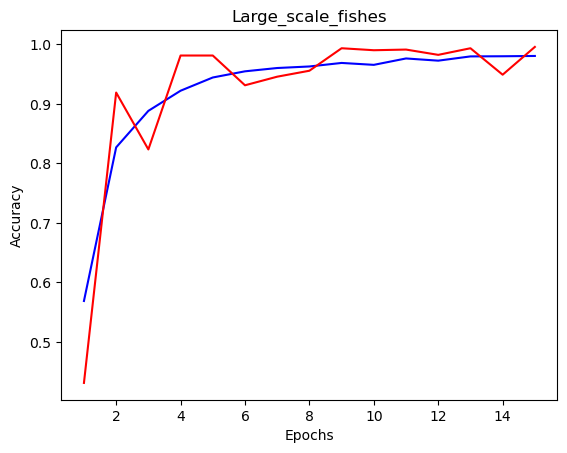

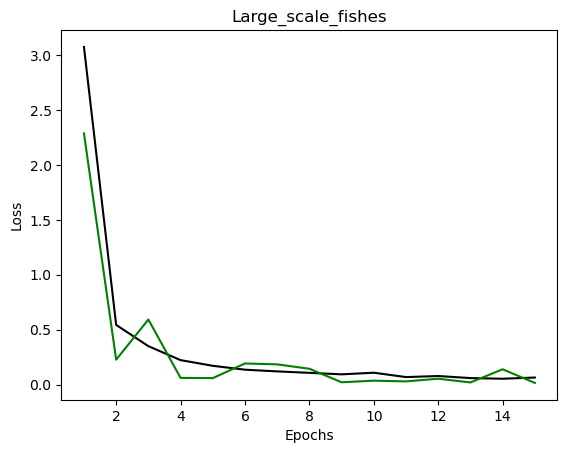

In [43]:
#Visualize models performance
import matplotlib.pyplot as plt
epoch = range(1,16)
results = history.history
plt.plot(epoch,results['accuracy'],'blue')
plt.plot(epoch,results['val_accuracy'],'red')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Large_scale_fishes')
plt.show()
plt.plot(epoch,results['loss'],'black')
plt.plot(epoch,results['val_loss'],'green')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Large_scale_fishes')
plt.show()